### This notebook provides the density of state with Qutip 

In [22]:
import qutip
qutip.__version__

'5.2.2'

System Hamiltonian constructed
Hilbert space dimension: 4

Computing Density of States for different Gamma values...

Processing Gamma = 0.50 (U/Gamma = 20.0)
  Peak at ω=0: 0.0066

Processing Gamma = 1.00 (U/Gamma = 10.0)
  Peak at ω=0: 0.0122

Processing Gamma = 2.00 (U/Gamma = 5.0)
  Peak at ω=0: 0.0188

Processing Gamma = 5.00 (U/Gamma = 2.0)
  Peak at ω=0: 0.0198

Processing Gamma = 10.00 (U/Gamma = 1.0)
  Peak at ω=0: 0.0168

Computation completed!


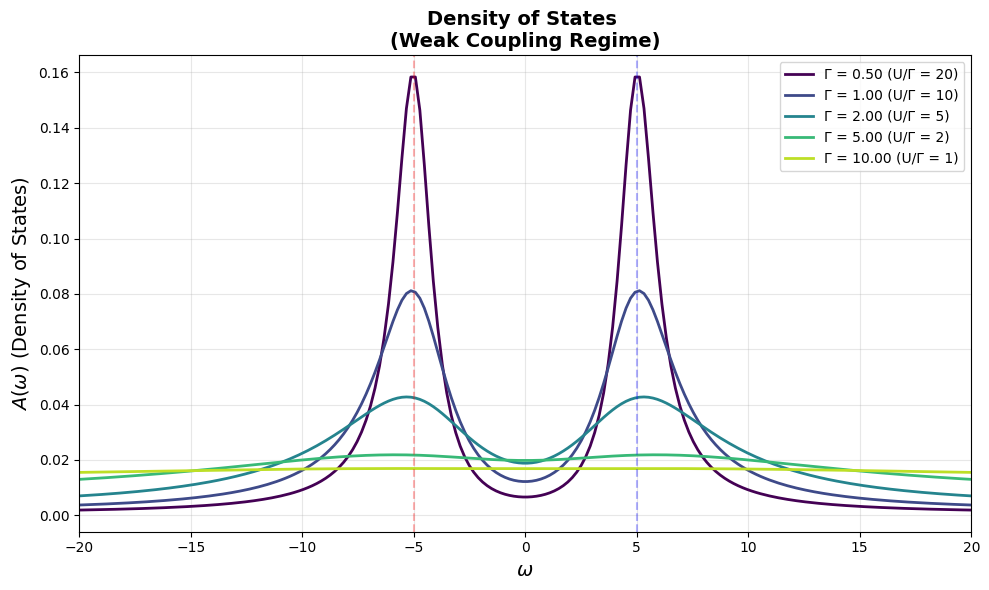


Plot saved as 'dos_qutip_anderson.png'

PHYSICAL INTERPRETATION:

System parameters:
  ε = -5.0 (impurity level)
  U = 10.0 (Coulomb repulsion)
  kT = 0.5 (temperature)

Expected features:
  - Lower Hubbard Band (LHB) around ω = ε = -5.0
  - Upper Hubbard Band (UHB) around ω = ε+U = 5.0
  - Kondo peak at ω = μ = 0.0

For Kondo regime: U > πΓ, i.e., Γ < 3.18
Your Γ values: [0.5, 1.0, 2.0, 5.0, 10.0]
All satisfy Kondo condition: False


In [1]:
"""
Density of States for Single Impurity Anderson Model
Using QuTiP 5.2.2
"""

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import warnings
warnings.filterwarnings('ignore')

# Physical parameters
epsilon = -5.0      # Impurity level
U = 10.0           # Coulomb repulsion
mu = 0.0           # Chemical potential
kT = 0.5           # Temperature
W = 10.0           # Bandwidth

# Weak coupling regime (to see Kondo peak)
#Gamma_list = [0.05, 0.1, 0.2, 0.5, 1.0]
Gamma_list = [0.5, 1.0, 2.0, 5.0, 10.0]

# Operators for the two-site quantum dot (spin-up and spin-down)
# Using Jordan-Wigner transformation
sigma_m = sigmam()
sigma_z = sigmaz()
II = qeye(2)

# Annihilation operators for spin-up and spin-down
d_up = tensor(sigma_m, II)
d_dn = tensor(-sigma_z, sigma_m)

# System Hamiltonian
H_sys = epsilon * (d_up.dag() * d_up + d_dn.dag() * d_dn) + \
        U * (d_up.dag() * d_up * d_dn.dag() * d_dn)

print("System Hamiltonian constructed")
print(f"Hilbert space dimension: {H_sys.shape[0]}")

def lorentzian_spectral_density(omega, Gamma, W):
    """Lorentzian spectral density J(ω)"""
    return (Gamma * W**2) / (omega**2 + W**2)

def create_lindblad_operators(d_op, Gamma, mu, W, kT, n_exp=5):
    """
    Create Lindblad collapse operators for fermionic bath
    Using Padé expansion for finite temperature
    """
    c_ops = []
    
    # Simple approximation: temperature-dependent rates
    # For a more accurate treatment, you would implement Padé decomposition
    
    # Emission process (particle leaves dot to bath)
    gamma_emission = Gamma
    c_ops.append(np.sqrt(gamma_emission) * d_op)
    
    # Absorption process (particle enters dot from bath)
    # Rate depends on Fermi function
    if kT > 0:
        gamma_absorption = Gamma * np.exp(-mu / kT)
    else:
        gamma_absorption = 0 if mu > 0 else Gamma
    
    c_ops.append(np.sqrt(gamma_absorption) * d_op.dag())
    
    return c_ops

def compute_correlation_spectrum(H, c_ops, A_op, B_op, omega_list, tlist):
    """
    Compute spectral function A(ω) from correlation functions
    A(ω) = Re{ ∫ dt [<A(t)B†(0)> + <B†(t)A(0)>] e^(iωt) }
    """
    # Find steady state
    rho_ss = steadystate(H, c_ops)
    
    # Calculate correlation function <d(t)d†(0)>
    # Using correlation_2op_1t (newer API in QuTiP 5.x)
    corr1 = correlation_2op_1t(H, rho_ss, tlist, c_ops, A_op, B_op.dag())
    
    # Calculate correlation function <d†(t)d(0)>
    corr2 = correlation_2op_1t(H, rho_ss, tlist, c_ops, B_op.dag(), A_op)
    
    # Total correlation
    corr_total = corr1 + corr2
    
    # Fourier transform to get spectral function
    dt = tlist[1] - tlist[0]
    spectrum = np.zeros(len(omega_list))
    
    for i, omega in enumerate(omega_list):
        # Compute ∫ dt corr(t) * e^(iωt)
        integrand = corr_total * np.exp(1j * omega * tlist)
        spectrum[i] = np.real(np.trapz(integrand, tlist))
    
    # Normalize by π
    spectrum = spectrum / np.pi
    
    return spectrum

# Time and frequency grids
tlist = np.linspace(0, 50, 500)
omega_list = np.linspace(-20, 20, 200)

# Store results
dos_results = {}

print("\nComputing Density of States for different Gamma values...")
print("=" * 60)

for Gamma in Gamma_list:
    print(f"\nProcessing Gamma = {Gamma:.2f} (U/Gamma = {U/Gamma:.1f})")
    
    # Create collapse operators for both spin channels
    c_ops_up = create_lindblad_operators(d_up, Gamma, mu, W, kT)
    c_ops_dn = create_lindblad_operators(d_dn, Gamma, mu, W, kT)
    c_ops = c_ops_up + c_ops_dn
    
    # Compute density of states for spin-up channel
    dos = compute_correlation_spectrum(H_sys, c_ops, d_up, d_up, 
                                       omega_list, tlist)
    
    dos_results[Gamma] = dos
    print(f"  Peak at ω=0: {dos[np.argmin(np.abs(omega_list))]:.4f}")

print("\n" + "=" * 60)
print("Computation completed!")

# Plotting
plt.figure(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.9, len(Gamma_list)))

for i, Gamma in enumerate(Gamma_list):
    plt.plot(omega_list, dos_results[Gamma], 
             label=f'Γ = {Gamma:.2f} (U/Γ = {U/Gamma:.0f})',
             color=colors[i], linewidth=2)

plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'$A(\omega)$ (Density of States)', fontsize=14)
plt.title('Density of States \n(Weak Coupling Regime)', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-20, 20)
plt.axvline(x=epsilon, color='red', linestyle='--', alpha=0.3, 
            label=f'ε = {epsilon}')
plt.axvline(x=epsilon+U, color='blue', linestyle='--', alpha=0.3,
            label=f'ε+U = {epsilon+U}')

# Add annotations
#plt.annotate('Kondo Peak', xy=(0, dos_results[0.05][np.argmin(np.abs(omega_list))]),
 #           xytext=(2, dos_results[0.05][np.argmin(np.abs(omega_list))] * 0.7),
  #          arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
   #         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('DOS_weak_py.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'dos_qutip_anderson.png'")

# Print physical interpretation
print("\n" + "=" * 60)
print("PHYSICAL INTERPRETATION:")
print("=" * 60)
print(f"\nSystem parameters:")
print(f"  ε = {epsilon} (impurity level)")
print(f"  U = {U} (Coulomb repulsion)")
print(f"  kT = {kT} (temperature)")
print(f"\nExpected features:")
print(f"  - Lower Hubbard Band (LHB) around ω = ε = {epsilon}")
print(f"  - Upper Hubbard Band (UHB) around ω = ε+U = {epsilon+U}")
print(f"  - Kondo peak at ω = μ = {mu}")
print(f"\nFor Kondo regime: U > πΓ, i.e., Γ < {U/np.pi:.2f}")
print(f"Your Γ values: {Gamma_list}")
print(f"All satisfy Kondo condition: {all(g < U/np.pi for g in Gamma_list)}")